# NER for Date


In [627]:
import re
import numpy as np
import matplotlib.pyplot as plt
import nltk
import math

from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

import tensorflow as tf
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, Dropout, Embedding, TimeDistributed, InputLayer, BatchNormalization
from tensorflow.keras.optimizers import Adam, RMSprop

from sklearn.model_selection import train_test_split

nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [628]:
np.random.seed(13517054)

## Load Data

In [629]:
def replace_with_entity(re_group):
    # replace every ENAMEX tag in sentence with the entity itself
    entity = re.findall(r'<ENAMEX TYPE=.*?>(.*?)</ENAMEX>', re_group)
    return entity[0]


def find_index_in_sentence(patterns, sentence):
    # find index of start and end of occured entity in sentence
    index_in_sentence = []
    for pattern in patterns:
        # add regex special characters in pattern with backslash
        pattern = re.sub('\(', '\\(', pattern)
        pattern = re.sub('\)', '\\)', pattern)
        pattern = re.sub('\+', '\\+', pattern)
        pattern = re.sub('\$', '\\$', pattern)

        index_in_sentence.append([(index.start(0), index.end(0)) for index in re.finditer(pattern, sentence)][0])

    return index_in_sentence


def read_enamex_file(filename):
    # open file with enamex XML Entities
    # convert it to standard SpaCy training dataset for NER
    with open(filename, 'r') as f:
        content = f.read()

    # remove \t...\n from the content data
    content_removed_endline = re.sub('\t.*?\n', '', content)

    # split the content to list of sentences
    before_sentences = content_removed_endline.split(".")
    train_data = []

    # converted the splitted content to list of tuple
    # showing where the entity occur and what's the entity
    for each_sentence in before_sentences:
        if each_sentence == "":
            continue
        # find enamex for every sentence
        entities = re.findall(r'<ENAMEX TYPE=.*?>(.*?)</ENAMEX>', each_sentence)
        types = re.findall(r'<ENAMEX TYPE=\"(.*?)\">.*?</ENAMEX>', each_sentence)

        # replace XML ENAMEX with entity
        new_sentence = re.sub(r'<ENAMEX TYPE=.*?>.*?</ENAMEX>', lambda enamex: replace_with_entity(enamex.group()), each_sentence)

        index_in_sentence = find_index_in_sentence(entities, new_sentence)

        #append to train data with format = (new_sentence, {"entities": [(start, end, type)]})
        entity_dictionary = {
            "entities": []
        }

        for entity_type, entity_index in zip(types, index_in_sentence):
            # only append if entities don't overlap
            check_overlap = False
            for entity in entity_dictionary["entities"]:
                if ((entity_index[0] >= entity[0] and entity_index[0] <= entity[1]) or (entity_index[1] <= entity[1] and entity_index[1] >= entity[0])):
                    check_overlap = True

            if (not check_overlap and entity_type == 'DATETIME'):
                entity_dictionary["entities"].append((entity_index[0], entity_index[1], entity_type))
        train_data.append((new_sentence, entity_dictionary))

    return train_data

In [630]:
data_read = read_enamex_file('ner_data.txt')
data_read[:3]

[('Telkom akan melakukan RUPS pada 30 Juli 2004 yang selain melaporkan kinerja 2003 juga akan meminta persetujuan untuk pemecahan nilai nominal saham atau stock split 1:2',
  {'entities': [(32, 44, 'DATETIME')]}),
 ('Sehubungan dengan hal tersebut, saat ini addendum (perubahan) terhadap perjanjian perpanjangan sewa jaringan PT PSN oleh KPU sedang dalam proses pertimbangan',
  {'entities': []}),
 ('Terutama mengenai langganan bulanan leased line channel untuk ruas Lemah Abang-Slipi (Jakarta-Excelcom) dan Lemah Abang-Imam Bonjol (Jakarta-Telkom) untuk tiga bulan ke depan yang sudah berakhir sejak 30 April 2004',
  {'entities': [(201, 214, 'DATETIME')]})]

## Data Preprocessing

In [631]:
def preprocessData(sentence):
  result = re.sub(r'[^ a-z A-Z 0-9]', " ", sentence.lower())
  result = nltk.word_tokenize(result)
  return result

def changeDataFormat(data_read):
  x_data = []
  y_data = []
  # Label 0 = other, 1 = date
  for data in data_read:
    words = preprocessData(data[0])
    label = [0 for i in range(len(words))]
    for entities in data[1]['entities']:

      ner_words = data[0][entities[0]:entities[1]]
      ner_words = preprocessData(ner_words)

      ner_count = 0
      idx_word = 0
      while (ner_count < len(ner_words) and idx_word < len(words)):
        if words[idx_word] == ner_words[ner_count]:
          label[idx_word] = 1
          ner_count += 1
        idx_word += 1
    x_data.append(words)
    y_data.append(label)
  return np.array(x_data), np.array(y_data)

In [632]:
cleaned_x, y = changeDataFormat(data_read)
cleaned_x[:3]

array([list(['telkom', 'akan', 'melakukan', 'rups', 'pada', '30', 'juli', '2004', 'yang', 'selain', 'melaporkan', 'kinerja', '2003', 'juga', 'akan', 'meminta', 'persetujuan', 'untuk', 'pemecahan', 'nilai', 'nominal', 'saham', 'atau', 'stock', 'split', '1', '2']),
       list(['sehubungan', 'dengan', 'hal', 'tersebut', 'saat', 'ini', 'addendum', 'perubahan', 'terhadap', 'perjanjian', 'perpanjangan', 'sewa', 'jaringan', 'pt', 'psn', 'oleh', 'kpu', 'sedang', 'dalam', 'proses', 'pertimbangan']),
       list(['terutama', 'mengenai', 'langganan', 'bulanan', 'leased', 'line', 'channel', 'untuk', 'ruas', 'lemah', 'abang', 'slipi', 'jakarta', 'excelcom', 'dan', 'lemah', 'abang', 'imam', 'bonjol', 'jakarta', 'telkom', 'untuk', 'tiga', 'bulan', 'ke', 'depan', 'yang', 'sudah', 'berakhir', 'sejak', '30', 'april', '2004'])],
      dtype=object)

In [633]:
MAX_LEN = 10
temp_0 = []
temp_1 = []
temp_y_0 = []
temp_y_1 = []
for j, x in enumerate(cleaned_x):
  for i in range(math.ceil(len(x)/float(MAX_LEN))):
    temp2 = np.array(y[j][MAX_LEN*i:MAX_LEN*(i+1)])
    if (np.all(temp2 == 0)):
      temp_0.append(x[MAX_LEN*i:MAX_LEN*(i+1)])
      temp_y_0.append(temp2)
    else:
      temp_1.append(x[MAX_LEN*i:MAX_LEN*(i+1)])
      temp_y_1.append(temp2)
temp_y_0 = np.array(temp_y_0)
temp_y_1 = np.array(temp_y_1)
temp_0 = np.array(temp_0)
temp_1 = np.array(temp_1)

In [634]:
print(len(temp_0))
print(len(temp_1))
print(len(temp_y_0))
print(len(temp_y_1))

4624
430
4624
430


In [635]:
taken = np.random.choice(temp_y_0.shape[0], int(temp_y_0.shape[0]*0.09))

In [636]:
len(temp_y_1)/len(taken)

1.0336538461538463

In [637]:
temp_y_0[taken]

array([array([0, 0, 0, 0, 0, 0]), array([0, 0, 0, 0, 0, 0, 0, 0]),
       array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
       array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
       array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([0, 0, 0, 0, 0]),
       array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([0, 0, 0]),
       array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
       array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
       array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([0, 0, 0, 0, 0, 0]),
       array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([0]),
       array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
       array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([0, 0, 0, 0, 0, 0]),
       array([0, 0, 0, 0]), array([0, 0, 0, 0]),
       array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
       array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
       array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
       array([0, 0, 0, 0, 0, 0, 0, 0, 0]), array([0, 0, 0, 0, 0, 0]),
       array([0, 0, 0, 0, 0, 0]), array([0, 0, 0, 0]),
       array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
       

In [638]:
temp_x = np.hstack((temp_0[taken], temp_1))

In [639]:
temp_y = np.hstack((temp_y_0[taken], temp_y_1))

In [640]:
print(temp_x.shape)
print(temp_y.shape)

(846,)
(846,)


## Feature Extraction

In [641]:
tokenizer = Tokenizer(filters = '!"#$%&()*+,-./:;<=>?@[\]^_`{|}~')
tokenizer.fit_on_texts(temp_x)

In [642]:
x_train = tokenizer.texts_to_sequences(temp_x)
x_train_pad = pad_sequences(x_train, maxlen=MAX_LEN, padding='post')
y_train_pad = pad_sequences(temp_y, maxlen=MAX_LEN, padding='post')

In [643]:
scaler = MinMaxScaler(feature_range=(-1, 1))
normalized_x  = scaler.fit_transform(x_train_pad)
# normalized_x = np.array(normalized_x)
normalized_x = np.reshape(normalized_x, (-1, MAX_LEN, 1))

In [644]:
normalized_x[1]

array([[-0.90617743],
       [-0.56728972],
       [-0.89053803],
       [-0.84227718],
       [-0.84141791],
       [-0.9981352 ],
       [-0.69338304],
       [-0.69130028],
       [-1.        ],
       [-1.        ]])

In [645]:
stacked_x = []
for i in range(len(normalized_x)):
  temp = []
  for j in range(len(normalized_x[i])):
    if (j == 0):
        temp.append([np.array([-1]), normalized_x[i][j], normalized_x[i][j+1]])
    elif (j == len(normalized_x[i])-1):
        temp.append([normalized_x[i][j-1], normalized_x[i][j], np.array([-1])])
    else:
        temp.append([normalized_x[i][j-1], normalized_x[i][j], normalized_x[i][j+1]])
  stacked_x.append(temp)

In [646]:
stacked_x = np.array(stacked_x)

In [647]:
stacked_x = stacked_x.reshape((stacked_x.shape[0], stacked_x.shape[1], stacked_x.shape[2]))

In [648]:
stacked_x.shape

(846, 10, 3)

In [649]:
y_train_pad.shape

(846, 10)

In [650]:
stacked_x[-1]

array([[-1.        , -0.94333488, -0.95794393],
       [-0.94333488, -0.95794393, -0.76994434],
       [-0.95794393, -0.76994434, -1.        ],
       [-0.76994434, -1.        , -1.        ],
       [-1.        , -1.        , -1.        ],
       [-1.        , -1.        , -1.        ],
       [-1.        , -1.        , -1.        ],
       [-1.        , -1.        , -1.        ],
       [-1.        , -1.        , -1.        ],
       [-1.        , -1.        , -1.        ]])

In [651]:
y_train_pad[-1]

array([1, 1, 1, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

## Model Training

In [660]:
x_train_final = x_train_pad
y_train_final = y_train_pad

In [661]:
model = Sequential()
model.add(InputLayer(input_shape=(MAX_LEN, )))
model.add(Embedding(len(tokenizer.word_index) + 1, 1024))
# model.add(Bidirectional(LSTM(256, return_sequences=True)))
# model.add(Dropout(0.6))
model.add(Bidirectional(LSTM(512, return_sequences=True)))
model.add(Dropout(0.6))
# model.add(TimeDistributed(Dense(512, activation='relu')))
# model.add(TimeDistributed(Dense(256, activation='elu')))
model.add(TimeDistributed(Dense(1, activation='sigmoid')))

In [662]:
prec = Precision(name='prec')
rec = Recall(name='rec')
opt = Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss="binary_crossentropy", metrics=["accuracy", prec, rec])
model.summary()

Model: "sequential_79"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_48 (Embedding)     (None, 10, 1024)          2208768   
_________________________________________________________________
bidirectional_140 (Bidirecti (None, 10, 1024)          6295552   
_________________________________________________________________
dropout_122 (Dropout)        (None, 10, 1024)          0         
_________________________________________________________________
time_distributed_98 (TimeDis (None, 10, 1)             1025      
Total params: 8,505,345
Trainable params: 8,505,345
Non-trainable params: 0
_________________________________________________________________


In [663]:
history = model.fit(x_train_final, y_train_final, batch_size=32, validation_split=0.1, epochs=100)

Epoch 1/100
24/24 [==============================] - 1s 62ms/step - loss: 0.3546 - accuracy: 0.8891 - prec: 0.6362 - rec: 0.3138 - val_loss: 0.1081 - val_accuracy: 0.9871 - val_prec: 0.9949 - val_rec: 0.9512
Epoch 2/100
24/24 [==============================] - 1s 29ms/step - loss: 0.0775 - accuracy: 0.9754 - prec: 0.9330 - rec: 0.8708 - val_loss: 0.1686 - val_accuracy: 0.9153 - val_prec: 0.9926 - val_rec: 0.6537
Epoch 3/100
24/24 [==============================] - 1s 30ms/step - loss: 0.0206 - accuracy: 0.9949 - prec: 0.9737 - rec: 0.9867 - val_loss: 0.0621 - val_accuracy: 0.9729 - val_prec: 1.0000 - val_rec: 0.8878
Epoch 4/100
24/24 [==============================] - 1s 31ms/step - loss: 0.0083 - accuracy: 0.9983 - prec: 0.9908 - rec: 0.9959 - val_loss: 0.1334 - val_accuracy: 0.9329 - val_prec: 1.0000 - val_rec: 0.7220
Epoch 5/100
24/24 [==============================] - 1s 30ms/step - loss: 0.0053 - accuracy: 0.9989 - prec: 0.9959 - rec: 0.9959 - val_loss: 0.0720 - val_accuracy: 0.96

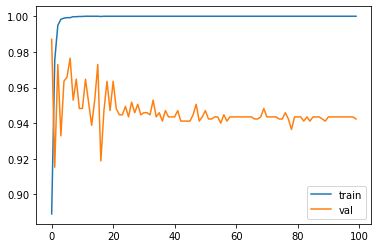

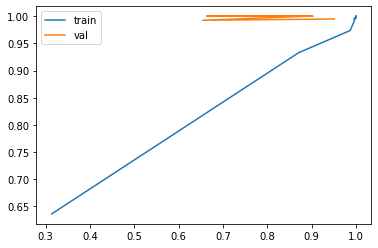

In [664]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['train', 'val'])
plt.show()
plt.plot(history.history['rec'], history.history['prec'])
plt.plot(history.history['val_rec'], history.history['val_prec'])
plt.legend(['train', 'val'])
plt.show()

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['train', 'val'])
plt.show()
plt.plot(history.history['rec'], history.history['prec'])
plt.plot(history.history['val_rec'], history.history['val_prec'])
plt.legend(['train', 'val'])
plt.show()

In [ ]:
plt.plot(history.history['prec'])
plt.plot(history.history['rec'])
plt.plot(history.history['val_prec'])
plt.plot(history.history['val_rec'])

In [665]:
def getIndex(data):
  for key in word2index:
    if word2index[key] == data:
      return key

def createStack(data):
  print(len(data[0]))
  stacked_x = []
  for i in range(len(data)):
    temp = []
    for j in range(len(data[i])):
      if (j == 0):
          temp.append([data[i][j], 0, data[i][j+1]])
      elif (j == len(data[i])-1):
          temp.append([data[i][j], data[i][j-1], 0])
      else:
          temp.append([data[i][j], data[i][j-1], data[i][j+1]])
    stacked_x.append(temp)
  return np.array(stacked_x)

def predict(text):
  test_data = preprocessData(text)
  test_data = tokenizer.texts_to_sequences(test_data)
  oov_handler_data = []
  for data in test_data:
    if (len(data) == 0):
      oov_handler_data.append(0)
    else:
      oov_handler_data.append(data[0])
  padded_data = pad_sequences([oov_handler_data], maxlen=MAX_LEN, padding='post')
  # print(padded_data)
  pred = model.predict(padded_data[0])
  print(pred)
  normalized_pred = [1 if a[0] > 0.5 else 0 for a in pred]

  labelled_word = []
  for token, label in zip(padded_data[0], normalized_pred):
    if label == 1:
      labelled_word.append(token)
  return tokenizer.sequences_to_texts([labelled_word])

In [686]:
text = 'saya izin cuti 1-2 februari dua ribu delapan belas februari asdf asdf asdf februari asdf'
predict(text)

[[[8.4274737e-03]]

 [[2.2783544e-02]]

 [[5.8517844e-04]]

 [[5.8517844e-04]]

 [[9.9995971e-01]]

 [[5.8517844e-04]]

 [[5.8517844e-04]]

 [[5.8517844e-04]]

 [[9.9995971e-01]]

 [[5.8517844e-04]]]


['februari februari']

In [689]:
model.save('./tes')

INFO:tensorflow:Assets written to: ./tes/assets


In [691]:
!zip -o -r ./tes.zip ./tes

updating: tes/ (stored 0%)
  adding: tes/variables/ (stored 0%)
  adding: tes/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: tes/variables/variables.index (deflated 67%)
  adding: tes/saved_model.pb (deflated 90%)
  adding: tes/assets/ (stored 0%)


In [693]:
text.split(' ')[::10]

['saya', 'asdf']

In [694]:
import pickle

In [696]:
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
